# Invicid Burgers Equation

$u_t + u u_x =0 $

$u_{0}(x,t) = u_0$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate


In [2]:
from sympy import init_printing
init_printing(use_latex=True)

In [3]:
'''
These are auxiliary functions in for the gradient
'''

def minmod2(x,y):
  return (np.sign(x) + np.sign(y))*np.minimum(np.abs(x), np.abs(y))/2

def minmod3(x,y,z):
  return minmod2(x,minmod2(y,z))

'''
other set of equivalent functions

def minmod2(x, y):
    return (np.sign(x) + np.sign(y)) * (x < y) * x + (y <= x) * y / 2

def minmod3(x, y, z):
    return minmod2(x, minmod2(y, z))
'''

'\nother set of equivalent functions\n\ndef minmod2(x, y):\n    return (np.sign(x) + np.sign(y)) * (x < y) * x + (y <= x) * y / 2\n\ndef minmod3(x, y, z):\n    return minmod2(x, minmod2(y, z))\n'

In [4]:
def getGradient(f, dx, theta=1):
    """
    Calculate the gradients of a field
    f        is a matrix of the field
    dx       is the cell size
    f_dx     is a matrix of derivative of f in the x-direction
    theta    is the flux limiter 1 <= theta <= 2

    """
    # directions for np.roll()
    R = -1   # right
    L = 1    # left

    df_dx = minmod3( theta * ( f - np.roll(f,L,axis=0) )/dx, (np.roll(f,R,axis=0) - np.roll(f,L,axis=0) ) / (2*dx),theta * ( np.roll(f,R,axis=0) - f ) / dx)

    return df_dx

def local_propagation_speed(u):

   '''
    Get the local propagation speeds using the eigenvalues
    of the flux matrix of the non relativistic IS equations

    u          is a matrix of density

    '''

   return u

In [5]:
def Euler(q , C , dt):
    '''
    Foward Euler timestep

    q   is the field we are updating
    C   is the dq/dt
    dt  is the timestep


    '''
    E = q + dt * C

    return E


def modified_RungeKutta(q, C, dt, s=2):
    '''
    Modified Runge-Kutta integrator

    q   is the field we are updating
    C   is the dq/dt
    dt  is the timestep
    s   is the optional parameter for the order of the integrator

    This integrator goes up to 3 order

    This function updates the q field by one timestep using the numerical
    derivative of q over time (Heun's Method)
    '''

    A = q.shape[0]
    try:
      B = q.shape[1]
      y = np.empty((s,A,B))
    except:
      y = np.empty((s,A))


    if s==2:

      y[0] = Euler(q,C,dt) # foward euler step
      y[1] = 0.5 * q + 0.5*Euler(y[0],C,dt)

    if s==3:
      pass

    return y[s-1]

In [6]:
def extrapolateInSpaceToFace(q, q_dx, dx):
  """
  Calculate the gradients of a field
  q        is a matrix of the field
  q_dx     is a matrix of the field x-derivatives
  dx       is the cell size
  q_XL     is a matrix of spatial-extrapolated values on `left' face along x-axis
  q_XR     is a matrix of spatial-extrapolated values on `right' face along x-axis
  """
  # directions for np.roll()
  R = -1   # right
  L = 1    # left


  qP_XL = q - q_dx * dx/2
  qP_XR = np.roll(q,R,axis=0) - np.roll(q_dx,R,axis=0) * dx/2
  qM_XR = q + q_dx * dx/2
  qM_XL = np.roll(q,L,axis=0) + np.roll(q_dx,L,axis=0) * dx/2


  return qM_XL, qP_XL, qM_XR, qP_XR

In [7]:
def getFlux(u_P, u_M):

  """

  Calculate fluxes between 2 states with local Kurganov Tadmor rule
  rho_P        is a matrix of left-state  density
  rho_M        is a matrix of right-state density

  """


  # compute fluxes (local Kurganov-Tadmor)

  flux_Mass   = 0.25*(u_P**2 + u_M**2)

  # find wavespeeds

  C_P = local_propagation_speed(u_P) # max propagation speed from the left

  C_M = local_propagation_speed(u_M) # max propagation speed from the right

  C = np.maximum(C_M, C_P)

  # add stabilizing diffusive term
  flux_Mass -= C * 0.5 * (u_P - u_M)

  return flux_Mass

In [8]:
def applyFluxes(flux_H1_X, flux_H2_X , dx, J = 0):

    """
    Apply fluxes to conserved variables
    H         is a matrix of the conserved variable field
    flux_H1_X is a matrix of the x-dir fluxes from the right
    flux_H2_X is a matrix of the x-dir fluxes from the left
    dx        is the cell size
    """

    C = 0

    # update solution
    C -= (flux_H1_X - flux_H2_X ) / dx
    C += J

    return C

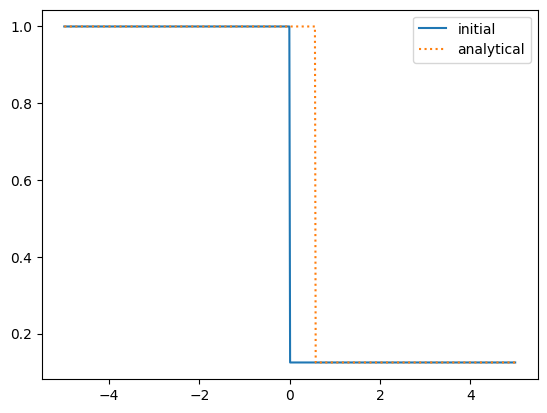

In [21]:

def linear_analytical_solution(t,x,a,b):

  u = (a * x + b ) / (a * t + 1)

  return u

def shock_analytical_solution(t,x,a,b,c):

  if x <= c + t*(a+b)/2:
    u = a
  else:
    u=b
  return u

# Simulation parameters
N                      = 600 # resolution
boxsize                = 10.  # in some unit system l
t                      = 1   # s
tinit                  = 0
tEnd                   = 1  # time at the end
tOut                   = 0.01 # time of each output
plotRealTime = False # switch on for plotting as the simulation goes along
#test parameters
flimit                 = 10**4  # Warns if fluxes are larger than this value
runFluxLimitTests      = False  # Switch to conduct tests
testTVD                = False



#-----------------------------------------------------------------------------------------------------------------------------------#

# Define Mesh
dx = boxsize / N   # box size
vol = dx**2        # volume of each box
a = -0.5*(boxsize-0.5*dx)
b =  0.5*(boxsize-0.5*dx)
xlin = np.linspace(a, b, N) # simulation limits

u = 1*(xlin < 0) + 0.125*(xlin >= 0)
u_analytical = np.asarray([shock_analytical_solution(t, xi, 1, 0.125,0) for xi in xlin])


plt.plot(xlin, u, label ="initial")
plt.plot(xlin, u_analytical, label = "analytical", linestyle="dotted")
plt.legend()

plt.show()


<ipython-input-22-8ae94e2b51d4>:46: RuntimeWarning: divide by zero encountered in double_scalars
  tau  = - 1/np.min(u_dx)


tau =  -inf
1.0000000000000095


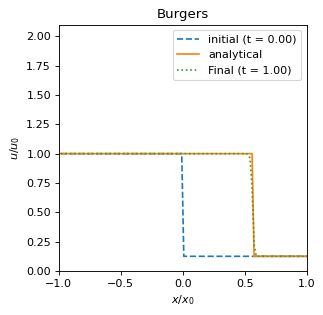

This is the evolved solution


<Figure size 640x480 with 0 Axes>

In [22]:
def main():

    """ Finite Volume simulation """

    # Simulation parameters
    N                      = 600 # resolution
    boxsize                = 10.  # in some unit system l
    t                      = 0   # s
    tinit                  = 0
    tEnd                   = 1  # time at the end
    tOut                   = 0.01 # time of each output
    plotRealTime = False # switch on for plotting as the simulation goes along
    #test parameters
    flimit                 = 10**4  # Warns if fluxes are larger than this value
    runFluxLimitTests      = False  # Switch to conduct tests
    testTVD                = False



    #-----------------------------------------------------------------------------------------------------------------------------------#

    # Define Mesh
    dx = boxsize / N   # box size
    vol = dx**2        # volume of each box
    a = -0.5*(boxsize-0.5*dx)
    b =  0.5*(boxsize-0.5*dx)
    xlin = np.linspace(a, b, N) # simulation limits


    #-----------------------------------------------------------------------------------------------------------------------------------#

    # Generate Initial Conditions

    ''' Initial conditions for rho '''

    #u = a * xlin + b*np.ones(xlin.shape)
    #u = (((1 - ((xlin - (boxsize-0.5*dx)*0.5)**2)/0.25 )**4 ) + 0.5*np.ones(xlin.shape)) # Mauricio's function advice
    #u = 1*(xlin < boxsize*0.5) + 0.125*(xlin > boxsize*0.5)
    #u = np.ones(xlin.shape) + np.sin(4*np.pi * xlin)
    u = 1*(xlin < 0) + 0.125*(xlin >= 0)
    uic = u


    # get caustic time (the time when the solution produces shocks)
    u_dx = getGradient(u,  dx)
    tau  = - 1/np.min(u_dx)
    print("tau = ", tau)


    #-----------------------------------------------------------------------------------------------------------------------------------#

    # prep figure
    fig = plt.figure(figsize=(4,4), dpi=80)
    outputCount = 1

    #-----------------------------------------------------------------------------------------------------------------------------------#


    # Simulation Main Loop

    while t < tEnd:

        # get time step
        prospeed = local_propagation_speed(u)
        courant_number = np.min(np.divide(dx,prospeed,out=np.zeros_like(dx*np.ones(u.shape)), where=prospeed!=0))
        dt = np.minimum(0.01, 0.1*courant_number)

        plotThisTurn = False

        if t + dt > outputCount*tOut:
            plotThisTurn = True

        #-----------------------------------------------------------------------------------------------------------------------------------#

        # calculate gradients
        # getGradient(f, dx, theta=1)

        u_dx = getGradient(u,  dx)

        #-----------------------------------------------------------------------------------------------------------------------------------#

        # extrapolate in space to face centers


        uM_XL, uP_XL, uM_XR, uP_XR = extrapolateInSpaceToFace(u, u_dx, dx)

        #-----------------------------------------------------------------------------------------------------------------------------------#

        # compute fluxes (local Kurganov-Tadmor)

        flux_u_XR = getFlux(uP_XR, uM_XR)
        flux_u_XL = getFlux(uP_XL, uM_XL)

        #-----------------------------------------------------------------------------------------------------------------------------------#

        # update solution

        #J = u_dx

        u   = modified_RungeKutta(u, applyFluxes( flux_u_XR,   flux_u_XL,   dx),    dt)

        #-----------------------------------------------------------------------------------------------------------------------------------#

        # Boundary conditions

        u[0] = u[1]
        u[-1] = u[-2]

        #-----------------------------------------------------------------------------------------------------------------------------------#
        # update time
        t += dt

        #-----------------------------------------------------------------------------------------------------------------------------------#

        # plot in real time
        if (plotRealTime and plotThisTurn) or (t >= tEnd):
            plt.cla()
            print(t)
            plt.plot(xlin,uic,label='initial (t = {:.2f})'.format(tinit), linestyle='dashed')
            plt.plot(xlin, u_analytical, label = "analytical")
            plt.plot(xlin,u,label='Final (t = {:.2f})'.format(t), linestyle="dotted")
            plt.xlabel("$x/x_0$")
            plt.ylabel("$u/u_0$")
            plt.title('Burgers')
            plt.xlim((-1,1))
            plt.ylim(0,2+0.1)
            plt.legend()
            plt.pause(0.001)
            outputCount += 1
       #-----------------------------------------------------------------------------------------------------------------------------------#
        #if (makeGIF and plotThisTurn):



    # Save figure
    plt.savefig('finitevolume.png',dpi=240)

    print("This is the evolved solution")
    plt.show()

    return 0



if __name__== "__main__":
  main()




Plot anaylical results of the burgers equations


I got the solution from mathematica and computed it analytically


# GIF of the solution

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML

In [ ]:

def Burgers(t_init,y,dx,xlin,theta=1):
  """ Burgers equation solve for each time step """


  #-----------------------------------------------------------------------------------------------------------------------------------#

  # Generate Initial Conditions
  u = y
  t = t_init

  #u[0] = u[1]
  #u[-1] = u[-2]

#-----------------------------------------------------------------------------------------------------------------------------------#

  # calculate gradients
  # getGradient(f, dx, theta=1)

  u_dx = getGradient(u,  dx, theta)

#-----------------------------------------------------------------------------------------------------------------------------------#

  # extrapolate in space to face centers

  uM_XL, uP_XL, uM_XR, uP_XR = extrapolateInSpaceToFace(u, u_dx, dx)

#-----------------------------------------------------------------------------------------------------------------------------------#

  # compute fluxes (local Rusanov)

  flux_u_XR = getFlux(uP_XR, uM_XR)
  flux_u_XL = getFlux(uP_XL, uM_XL)


#-----------------------------------------------------------------------------------------------------------------------------------#

  # get time derivative

  dudt   = applyFluxes( flux_u_XR,   flux_u_XL,  dx)

#-----------------------------------------------------------------------------------------------------------------------------------#


  return dudt



In [ ]:
# Simulation parameters
N                      = 64  # resolution
boxsize                = 10. # in some unit system l
t                      = 0   # s
tEnd                   = 1   # time at the end
a = 8
b = 1
dx = boxsize / N   # box size
vol = dx**2        # volume of each box
xlin = np.linspace((-0.5)*(boxsize-dx*0.5), (boxsize-0.5*dx)*0.5, N)


u = a*xlin + b*np.ones(xlin.shape)

#max_step               = np.minimum(0.01, 0.4*np.min(dx/local_propagation_speed(u)))
solution = integrate.solve_ivp(Burgers, (t,tEnd), u, args=(dx,xlin), method="RK23")

u_analytical = np.asarray([linear_analytical_solution(tEnd, xi, a, b) for xi in xlin])

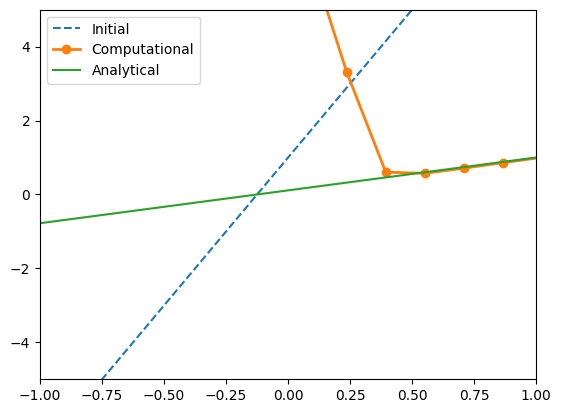

In [ ]:
plt.plot(xlin, solution.y[:,0],linestyle='dashed',label='Initial')
plt.plot(xlin, solution.y[:,-1], marker='o', lw=2, label='Computational')
plt.plot(xlin, u_analytical, label='Analytical')
plt.xlim(-2,2)
plt.ylim(-5,5)
plt.legend()
plt.show()

(64, 1063)


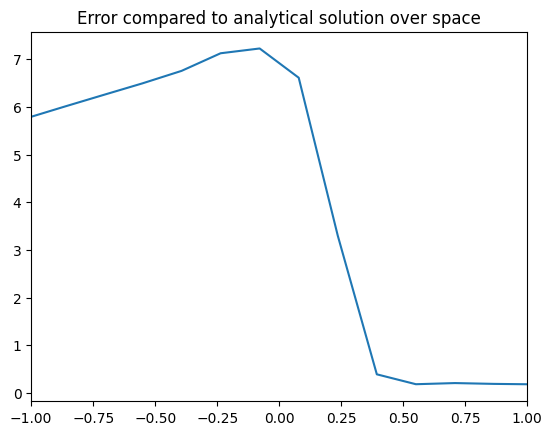

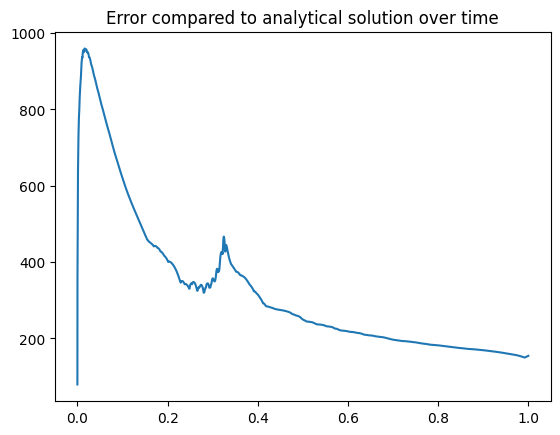

In [ ]:
def difference(xlin,a,b,t,tEnd,dx):

  solution = integrate.solve_ivp(Burgers, (t,tEnd), a*xlin+b*np.ones(xlin.shape), args=(dx,xlin), method="RK23")
  times = np.linspace(t,tEnd, len(solution.t))
  u_analytical = np.asarray([linear_analytical_solution(times, xi, a, b) for xi in xlin])
  r = np.sqrt(np.abs(u_analytical**2 - solution.y**2))
  print(r.shape)
  err = np.sum(r,axis=0)

  plt.cla()
  plt.plot(xlin,r[:,-1])
  plt.title('Error compared to analytical solution over space')
  plt.xlim((-1,1))
  plt.show()
  plt.plot(solution.t,err)
  plt.title('Error compared to analytical solution over time')
  plt.show()

difference(xlin,a,b,t,tEnd,dx)


In [ ]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)


def animate_Burgers(i):
  #x = xlin
  #y = solution1.y[:,i]
  #line.set_data(x, y)
  x = xlin
  y = solution2.y[:,i]
  line.set_data(x, y)
  return (line,)

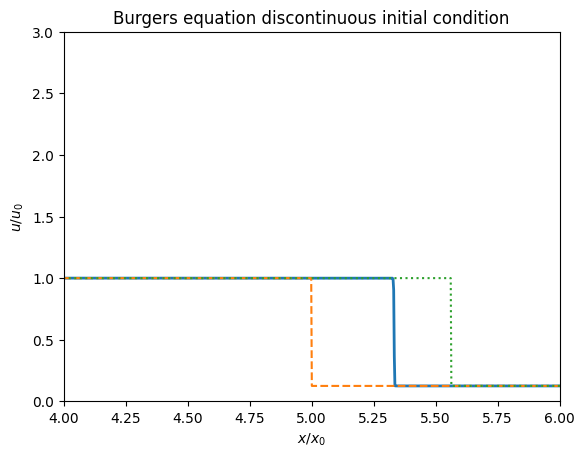

In [ ]:

%matplotlib inline

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()


# Simulation parameters
N                      = 4000 # resolution
boxsize                = 10.  # in some unit system l
t                      = 0   # s
tEnd                   = 1   # time at the end

# Define Mesh
dx = boxsize / N   # box size
xlin = np.linspace(0, boxsize-0.5*dx, N) # simulation limits

# set ax boundaries
ax.set_xlim((4,6))
ax.set_ylim((0, 3))
ax.set_xlabel('$x/x_0$')
ax.set_ylabel('$u/u_0$')
ax.set_title('Burgers equation discontinuous initial condition')
line, = ax.plot([], [], lw=2)

u = 1*(xlin < boxsize*0.5) + 0.125*(xlin >= boxsize*0.5)

max_step               = np.minimum(0.01, 0.5*np.min(dx/local_propagation_speed(u)))
solution1 = integrate.solve_ivp(Burgers, (t,tEnd), u, args=(dx,xlin,1), method="RK45")
solution2 = integrate.solve_ivp(Burgers, (t,tEnd), u, args=(dx,xlin,2), method="RK45")

u_analytical = np.asarray([shock_analytical_solution(tEnd, xi, 1, 0.125, boxsize*0.5) for xi in xlin])


# plot initial conditions for density
plt.plot(xlin,solution1.y[:,0],linestyle='dashed')

# plot the analytical solution
plt.plot(xlin,u_analytical,linestyle='dotted')

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate_Burgers, init_func=init,
                               frames=200, interval=20, blit=True)

anim.save("BurgersStepFunction.gif")


In [ ]:
HTML(anim.to_html5_video())

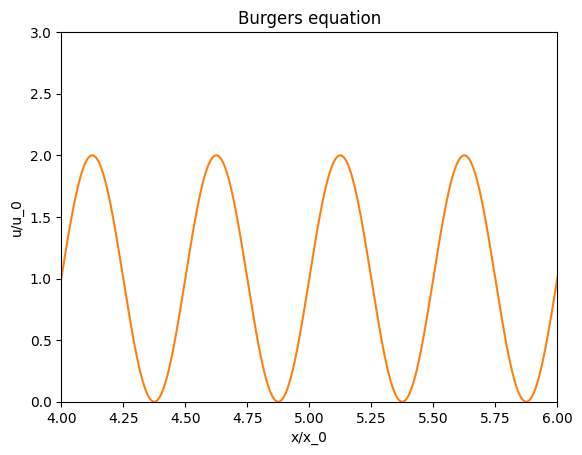

In [ ]:
%matplotlib inline

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()


# Simulation parameters
N                      = 4000 # resolution
boxsize                = 10.  # in some unit system l
t                      = 0   # s
tEnd                   = 10   # time at the end

# Define Mesh
dx = boxsize / N   # box size
xlin = np.linspace(0, boxsize-0.5*dx, N) # simulation limits

ax.set_xlim((4,6))
ax.set_ylim((0, 3))
ax.set_xlabel('x/x_0')
ax.set_ylabel('u/u_0')
ax.set_title('Burgers equation')
line, = ax.plot([], [], lw=2)

u = np.ones(xlin.shape) + np.sin(4 * np.pi * xlin) # Initial condition on Rezzolla page 204-206
max_step = np.minimum(0.01, 0.5*np.min(dx/local_propagation_speed(u)))

solution = integrate.solve_ivp(Burgers, (t,tEnd), u, args=(dx,xlin), vectorized=True)

# plot initial conditions for density
plt.plot(xlin,solution.y[:,0])
plt.show()

# call the animator. blit=True means only re-draw the parts that have changed.
# animate the density in each box dx over time
anim1 = animation.FuncAnimation(fig, animate_Burgers, init_func=init,
                               frames=1000, interval=20, blit=True)

anim1.save("Burgers.gif")

In [ ]:
HTML(anim1.to_html5_video())

# Burgers in 2d


inviscid:

$ \partial_t u + u ∇ u = 0$

Flux conservative form:

$ \partial_t u + \nabla u^2 / 2 = 0$


Some aspects of the above code have to change because of the increase in dimensionality.

The function numpy.roll is useful in one dimension, but since it will roll an array we have to be more careful with it.

In [ ]:
'''
def getGradient(f, dx, axis=0, theta=1):
    """
    Calculate the gradients of a field
    f        is a matrix of the field
    dx       is the cell size in x direction
    axis     is the axis of x-direction
    f_dx     is a matrix of derivative of f in the x-direction
    theta    is the flux limiter 1 <= theta <= 2

    """

    df_dx = np.zeros(f.shape)
    n = f.shape[axis]

    for i in range(1,n-1):
        gi = np.take(f,indices=i, axis=axis)
        giP1 = np.take(f,indices=i+1, axis=axis)
        giM1 = np.take(f,indices=i-1, axis=axis)
        dg_dx = np.zeros(gi.shape)
        dg_dx = minmod3( theta * ( gi - giM1 )/dx, (giP1 - giM1 ) / (2*dx),theta * ( giP1 - gi ) / dx)
        if axis == 0:
          np.put_along_axis(df_dx, indices=np.array([[i]]).T, values=dg_dx.reshape(1,-1), axis=axis)
        elif axis == 1:
          np.put_along_axis(df_dx, indices=np.array([[i]]), values=dg_dx.reshape(-1,1), axis=axis)

    return df_dx
'''
'''
def getGradient(f, dx, axis=0, theta=1):
    """
    Calculate the gradients of a field
    f        is a matrix of the field
    dx       is the cell size in x direction
    axis     is the axis of x-direction
    f_dx     is a matrix of derivative of f in the x-direction
    theta    is the flux limiter 1 <= theta <= 2
    """

    df_dx = np.zeros_like(f)
    n = f.shape[axis]

    slices = [slice(None)] * f.ndim
    slices[axis] = slice(1, -1)

    gi = f[slices]
    giP1 = f[slices[:-1] + [slice(2, None)]]
    giM1 = f[slices[:-1] + [slice(None, -2)]]

    dg_dx = np.zeros_like(gi)
    dg_dx = minmod3(theta * (gi - giM1) / dx,
                    (giP1 - giM1) / (2 * dx),
                    theta * (giP1 - gi) / dx )

    if axis == 0:
        df_dx[1:-1] = dg_dx
    elif axis == 1:
        df_dx[:, 1:-1] = dg_dx

    return df_dx

'''
'''
def extrapolateInSpaceToFace(q, q_dx, dx, axis=0):

  """
  Calculate the gradients of a field
  q        is a matrix of the field
  q_dx     is a matrix of the field x-derivatives
  dx       is the cell size
  q_XL     is a matrix of spatial-extrapolated values on `left' face along x-axis
  q_XR     is a matrix of spatial-extrapolated values on `right' face along x-axis
  """

  n = q.shape[axis]

  qM_XL=np.zeros(q.shape)
  qP_XL=np.zeros(q.shape)
  qM_XR=np.zeros(q.shape)
  qP_XR=np.zeros(q.shape)

  for i in range(1,n-1):

    gi = np.take(q,indices=i, axis=axis)
    giP1 = np.take(q,indices=i+1, axis=axis)
    giM1 = np.take(q,indices=i-1, axis=axis)
    gi_dx = np.take(q_dx,indices=i, axis=axis)
    giP1_dx = np.take(q_dx,indices=i+1, axis=axis)
    giM1_dx = np.take(q_dx,indices=i-1, axis=axis)

    gP_XL = gi - gi_dx * dx/2
    gP_XR = giP1 - giP1_dx * dx/2
    gM_XR = gi + gi_dx * dx/2
    gM_XL = giM1 + giM1_dx * dx/2

    if axis == 0:
      np.put_along_axis(qP_XL, indices=np.array([[i]]), values=gP_XL.reshape(1,-1), axis=axis)
      np.put_along_axis(qP_XR, indices=np.array([[i]]), values=gP_XR.reshape(1,-1), axis=axis)
      np.put_along_axis(qM_XR, indices=np.array([[i]]), values=gM_XR.reshape(1,-1), axis=axis)
      np.put_along_axis(qM_XL, indices=np.array([[i]]), values=gM_XL.reshape(1,-1), axis=axis)
    elif axis == 1:
      np.put_along_axis(qP_XL, indices=np.array([[i]]), values=gP_XL.reshape(-1,1), axis=axis)
      np.put_along_axis(qP_XR, indices=np.array([[i]]), values=gP_XR.reshape(-1,1), axis=axis)
      np.put_along_axis(qM_XR, indices=np.array([[i]]), values=gM_XR.reshape(-1,1), axis=axis)
      np.put_along_axis(qM_XL, indices=np.array([[i]]), values=gM_XL.reshape(-1,1), axis=axis)

  return qM_XL, qP_XL, qM_XR, qP_XR
'''
'''
def extrapolateInSpaceToFace(q, q_dx, dx, axis=0):
    """
    Calculate the gradients of a field
    q        is a matrix of the field
    q_dx     is a matrix of the field x-derivatives
    dx       is the cell size
    q_XL     is a matrix of spatial-extrapolated values on `left' face along x-axis
    q_XR     is a matrix of spatial-extrapolated values on `right' face along x-axis
    """
    n = q.shape[axis]
    slices = [slice(None)] * q.ndim
    slices[axis] = slice(1, n-1)
    slices = tuple(slices)

    gi = np.take(q, indices=slices, axis=axis)
    giP1 = np.take(q, indices=slices+([slice(1,None)] if axis == 0 else [slice(None),slice(1,None)]), axis=axis)
    giM1 = np.take(q, indices=slices+([slice(None,-1)] if axis == 0 else [slice(None),slice(None,-1)]), axis=axis)
    gi_dx = np.take(q_dx, indices=slices, axis=axis)
    giP1_dx = np.take(q_dx, indices=slices+([slice(1,None)] if axis == 0 else [slice(None),slice(1,None)]), axis=axis)
    giM1_dx = np.take(q_dx, indices=slices+([slice(None,-1)] if axis == 0 else [slice(None),slice(None,-1)]), axis=axis)

    gP_XL = gi - gi_dx * dx/2
    gP_XR = giP1 - giP1_dx * dx/2
    gM_XR = gi + gi_dx * dx/2
    gM_XL = giM1 + giM1_dx * dx/2

    qP_XL = np.zeros_like(q)
    qP_XR = np.zeros_like(q)
    qM_XR = np.zeros_like(q)
    qM_XL = np.zeros_like(q)

    if axis == 0:
        np.put_along_axis(qP_XL, indices=np.array([[slice(1,n-1)], [slice(None)]]).T, values=gP_XL, axis=axis)
        np.put_along_axis(qP_XR, indices=np.array([[slice(1,n-1)], [slice(None)]]).T, values=gP_XR, axis=axis)
        np.put_along_axis(qM_XR, indices=np.array([[slice(1,n-1)], [slice(None)]]).T, values=gM_XR, axis=axis)
        np.put_along_axis(qM_XL, indices=np.array([[slice(1,n-1)], [slice(None)]]).T, values=gM_XL, axis=axis)
    elif axis == 1:
        np.put_along_axis(qP_XL, indices=np.array([[slice(None)], [slice(1,n-1)]]).T, values=gP_XL, axis=axis)
        np.put_along_axis(qP_XR, indices=np.array([[slice(None)], [slice(1,n-1)]]).T, values=gP_XR, axis=axis)
        np.put_along_axis(qM_XR, indices=np.array([[slice(None)], [slice(1,n-1)]]).T, values=gM_XR, axis=axis)
        np.put_along_axis(qM_XL, indices=np.array([[slice(None)], [slice(1,n-1)]]).T, values=gM_XL, axis=axis)

    return qM_XL, qP_XL, qM_XR, qP_XR
'''

def getGradient(f, dx, axis=0, theta=1):
    """
    Calculate the gradients of a field
    f        is a matrix of the field
    dx       is the cell size in x direction
    axis     is the axis of x-direction
    f_dx     is a matrix of derivative of f in the x-direction
    theta    is the flux limiter 1 <= theta <= 2

    """


    df_dx = np.zeros(f.shape)
    n = f.shape[axis]
    K = np.arange(0, n)
    Kp1 = np.roll(K, -1)
    Km1 = np.roll(K, 1)

    if axis == 0:
      df_dx =  minmod3( theta * ( f - f[Km1][:, K] )/dx, (f[Kp1][:, K] - f[Km1][:, K] ) / (2*dx),theta * ( f[Kp1][:, K] - f ) / dx)
    elif axis == 1:
      df_dx = minmod3( theta * ( f - f[K][:, Km1] )/dx, (f[K][:, Kp1] - f[K][:, Km1] ) / (2*dx),theta * ( f[K][:, Kp1] - f ) / dx)

    return df_dx


def extrapolateInSpaceToFace(q, q_dx, dx, axis=0):
    """
    Calculate the gradients of a field
    q        is a matrix of the field
    q_dx     is a matrix of the field x-derivatives
    dx       is the cell size
    q_XL     is a matrix of spatial-extrapolated values on `left' face along x-axis
    q_XR     is a matrix of spatial-extrapolated values on `right' face along x-axis
    """

    n,_ = q.shape

    K = np.arange(0, n)
    Kp1 = np.roll(K, -1)
    Km1 = np.roll(K, 1)


    qP_XL = np.zeros_like(q)
    qP_XR = np.zeros_like(q)
    qM_XR = np.zeros_like(q)
    qM_XL = np.zeros_like(q)

    if axis == 0:
      qP_XL = q - q_dx * dx/2
      qP_XR = q[Kp1][:, K] - q_dx[Kp1][:, K] * dx/2
      qM_XR = q + q_dx * dx/2
      qM_XL = q[Km1][:, K] + q_dx[Km1][:, K] * dx/2

    elif axis == 1:
      qP_XL = q - q_dx * dx/2
      qP_XR = q[K][:, Kp1] - q_dx[K][:, Kp1] * dx/2
      qM_XR = q + q_dx * dx/2
      qM_XL = q[K][:, Km1] + q_dx[K][:, Km1] * dx/2


    return qM_XL, qP_XL, qM_XR, qP_XR


def applyFluxes(flux_H1_X, flux_H2_X, flux_H1_Y, flux_H2_Y, dx, dy, J = 0):
    """
    Apply fluxes to conserved variables
    H         is a matrix of the conserved variable field
    flux_H1_X is a matrix of the x-dir fluxes from the right
    flux_H2_X is a matrix of the x-dir fluxes from the left
    flux_H1_Y is a matrix of the y-dir fluxes from the right
    flux_H2_Y is a matrix of the y-dir fluxes from the left
    dx        is the cell size in the x direction
    dy        is the cell size in the y direction
    """
    C = 0

    # update solution
    C -= (flux_H1_X - flux_H2_X ) / dx
    C -= (flux_H1_Y - flux_H2_Y ) / dy
    C += J

    return C

def Burgers(t_init,q,dx,dy,X,Y,explicit_in_time=0):
  """ Burgers equation solve for each time step """

  #-----------------------------------------------------------------------------------------------------------------------------------#

  # Generate Initial Conditions

  u = q


  u[0] = u[1]
  u[-1] = u[-2]
  u[:][:,0] = u[:][:,1]
  u[:][:,-1] = u[:][:,-2]

#-----------------------------------------------------------------------------------------------------------------------------------#

  # calculate gradients
  # getGradient(f, dx, theta=1)

  u_dx = getGradient(u,  dx, 0)
  u_dy = getGradient(u,  dy, 1)

#-----------------------------------------------------------------------------------------------------------------------------------#

  # extrapolate in space to face centers

  uM_XL, uP_XL, uM_XR, uP_XR = extrapolateInSpaceToFace(u, u_dx, dx,0)
  uM_YL, uP_YL, uM_YR, uP_YR = extrapolateInSpaceToFace(u, u_dy, dy,1)

#-----------------------------------------------------------------------------------------------------------------------------------#

  # compute fluxes (local Kurganov-Tadmor)

  flux_u_XR = getFlux(uP_XR, uM_XR)
  flux_u_XL = getFlux(uP_XL, uM_XL)
  flux_u_YR = getFlux(uP_YR, uM_YR)
  flux_u_YL = getFlux(uP_YL, uM_YL)

#-----------------------------------------------------------------------------------------------------------------------------------#

  # get time derivative

  dudt   = applyFluxes( flux_u_XR, flux_u_XL, flux_u_YR, flux_u_YL, dx, dy)

#-----------------------------------------------------------------------------------------------------------------------------------#

  return dudt

In [ ]:
def Euler(q , C , dt):
    '''
    Foward Euler timestep

    q   is the field we are updating
    C   is the dq/dt
    dt  is the timestep


    '''
    E = q + dt * C

    return E


def modified_RungeKutta(q, C, dt, s=2):

    '''
    Modified Runge-Kutta integrator

    q   is the field we are updating
    C   is the dq/dt
    dt  is the timestep
    s   is the optional parameter for the order of the integrator

    This function updates the q field by one timestep using the numerical
    derivative of q over time (Heun's Method if s = 2)
    I did not implement higher order RK yet
    '''

    bl = 0.5

    A = q.shape[0]
    try:
      B = q.shape[1]
      y = np.empty([s,A,B])
    except:
      y = np.empty([s,A])

    y[0:] = Euler(q,C,dt) # foward euler step

    for i in range(s):
        y[i] = bl * q + (1 - bl)*Euler(y[0],C,dt)

    return y[s-1]

def Heuns(q,f,dt,t,ExplicitTimeDependence):

  k1 = dt*f(t,q)
  if ExplicitTimeDependence:
    k2 = dt*f(t + dt,q + k1)
  else:
    k2 = dt*(Euler(q + dt*k1,f(t,q + k1),dt))

  return q + 1/2 * (k1 + k2)

def RK4(y0,f,h,t):

  k1 = h * (f(t, y0))
  k2 = h * (f((t+h/2), (y0+k1/2)))
  k3 = h * (f((t+h/2), (y0+k2/2)))
  k4 = h * (f((t+h), (y0+k3)))
  k = (k1+2*k2+2*k3+k4)/6
  yn = y0 + k

  return yn

def integrator(scheme, time, q0, dtmax, BC, method = "Heuns", args=None):

  '''
  This is an integrator that evolves a

  scheme     is the method to get dy/dt e.g. KTscheme
  time       is the current time
  q0         is the current state
  dtmax      is the upperbound of dt set by the user
  BC         is a function that enforces the boundary conditions
  method     is the method used in the integrator
  args       are additional arguments for scheme
  '''

  if args is not None:
        # Wrap the user's scheme in lambdas to hide the
        # additional parameters.  Pass in the original fun as a keyword
        # argument to keep it in the scope of the lambda.
        try:
            _ = [*(args)]
        except TypeError as exp:
            suggestion_tuple = (
                "Supplied 'args' cannot be unpacked. Please supply `args`"
                f" as a tuple (e.g. `args=({args},)`)")
            raise TypeError(suggestion_tuple) from exp

        scheme = lambda t, x, scheme = scheme: scheme(t, x, *args)

  t, tEnd = time

  Q = [q0]
  q = q0
  N = int(args[2].shape[0])

  while t < tEnd:

    C = scheme

    # condition to ensure that the time steps are small enough so that
    # waves do not interfere with each other

    courant_number = dx/np.max(local_propagation_speed(q))
    dt  =  np.minimum(dtmax, 0.5*courant_number)

    if method == "Heuns":
      q = Heuns(q,C,dt,t,args[-1])
    if method == "RK4":
      q = RK4(q,C,dt,t)
    if method ==  "modified_RungeKutta":
      q = modified_RungeKutta(q,C(t,q),dt)

    #Apply Boundary conditions

    # BC(q)

    Q.append(q)

    t = t+dt

  return Q


In [ ]:
def animate_Burgers(i):
  x = X
  y = Y
  z = solution[i]
  ax.plot_surface(x, y, z)
  return ax,

In [ ]:

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})


# Simulation parameters
N                      = 1000 # resolution
boxsize                = 10.  # in some unit system l
t                      = 0   # s
tEnd                   = 4   # time at the end

# Define Mesh
dx = boxsize / N   # box size
dy = dx
xlin = np.linspace(-0.5*(boxsize-0.5*dx), 0.5*(boxsize-0.5*dx), N) # simulation limits
X,Y = np.meshgrid(xlin,xlin)

R = np.sqrt(X**2 + Y**2)
u = 1*(R <= 4*0.25) + 0.125*(R > 4*0.25)
# u = 1*(X <= 4*0.25) + 0.125*(X > 4*0.25)


solution = integrator(Burgers, (t,tEnd), u, 0.01, None, args=(dx,dy,X,Y,False))



0
0.005
0.009987531172069826
0.014962655550179279
0.019925434706506824
0.024875929756011776
0.02981420136095005
0.03474030973533429
0.0396543146493392
0.04455627543365293
0.04944625098377518
0.05432429976426299
0.059190479812924794
0.06404484874496363
0.06888746375707018
0.07371838163146632
0.07853765873990007
0.08334535104759239
0.08814151411713675
0.09292620311235206
0.09769947280208953
0.1024613775639943
0.10721197138822233
0.11195130788111333
0.1166794402688202
0.12139642140089568
0.12610230375383685
0.13079713943458804
0.13548098018400256
0.14015387738026425
0.14481588204226892
0.1494670448329666
0.15410741606266498
0.15873704569229463
0.16335598333663645
0.16796427826751203
0.17256197941693732
0.17714913538024007
0.1817257944191417
0.1862920044648038
0.19084781312084023
0.19539326766629478
0.19992841505858502
0.2044533019364131
0.20896797462264335
0.21347247912714787
0.2179668611496198
0.22245116608235524
0.22692543901300402
0.23138972472728975
0.23584406771169955
0.2402885121561

261


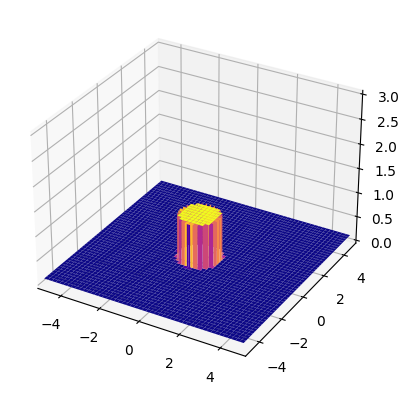

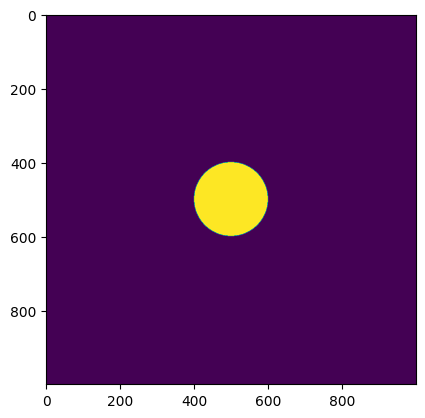

In [ ]:
from matplotlib.ticker import LinearLocator
from mpl_toolkits import mplot3d
%matplotlib inline

print(len(solution))

plt.imshow(solution[0])

# Customize the z axis.
ax.set_zlim(0, 3.01)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

surf = ax.plot_surface(X,Y,solution[0], cmap="plasma")
ax.view_init()
fig.canvas.flush_events()
fig

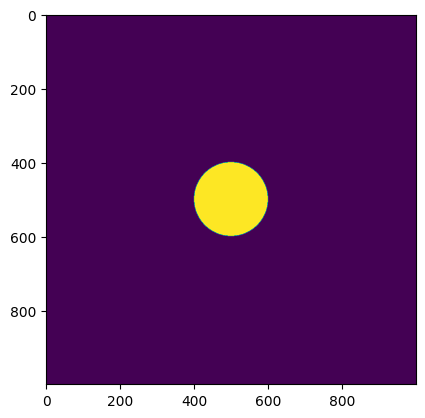

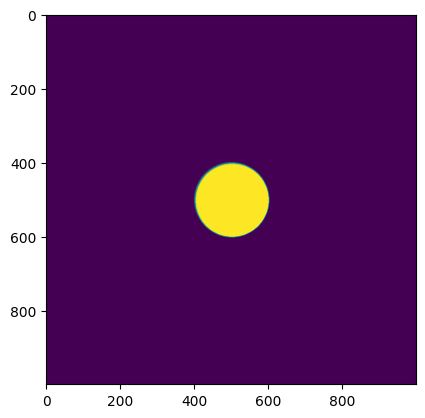

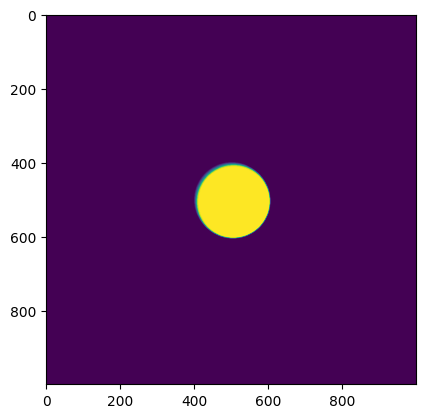

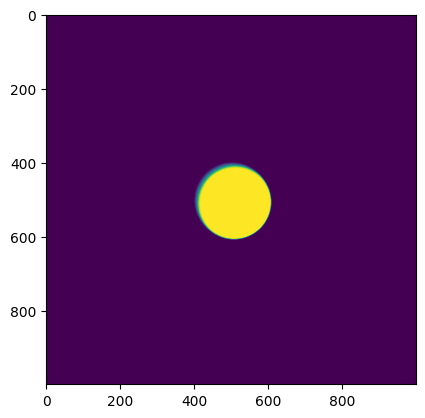

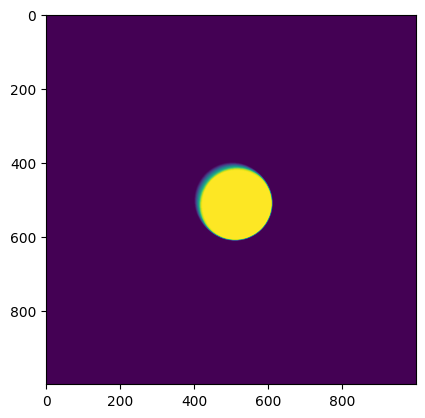

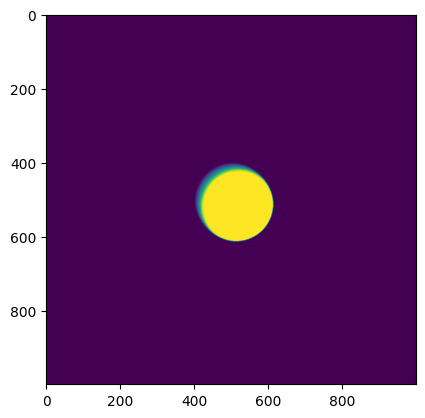

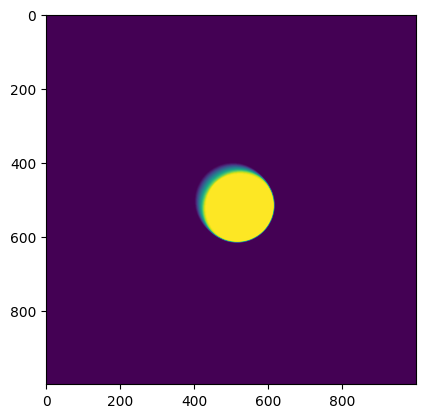

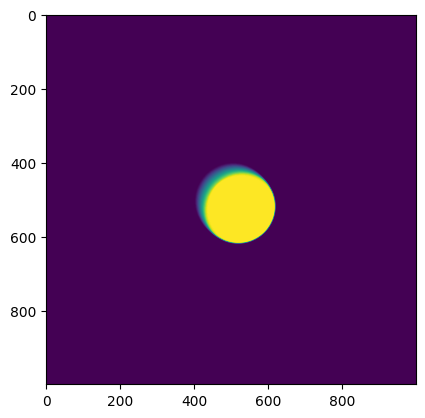

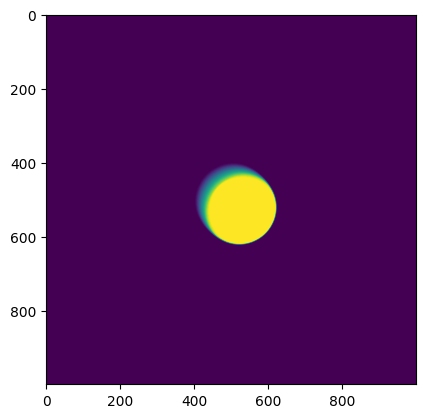

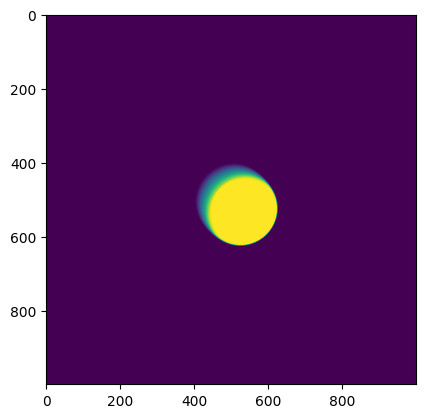

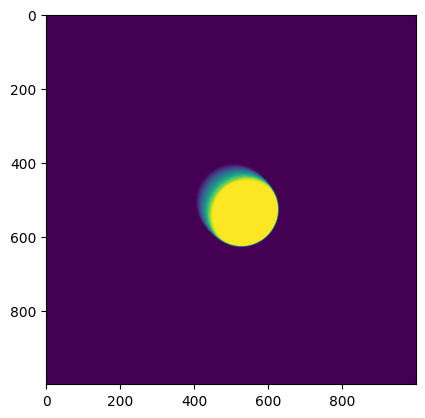

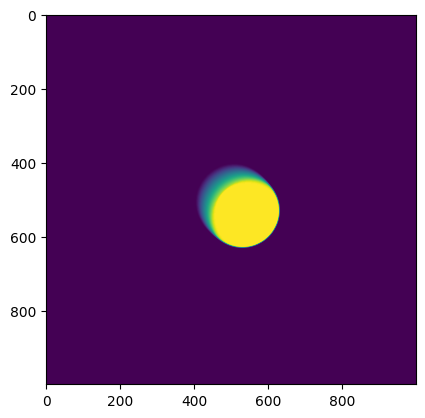

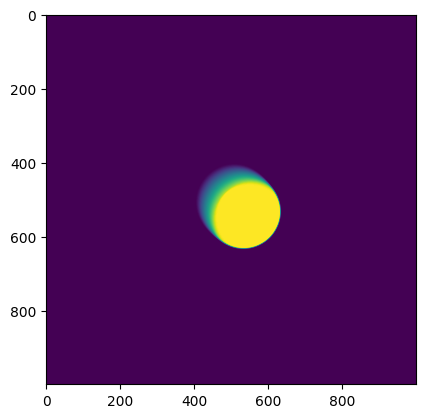

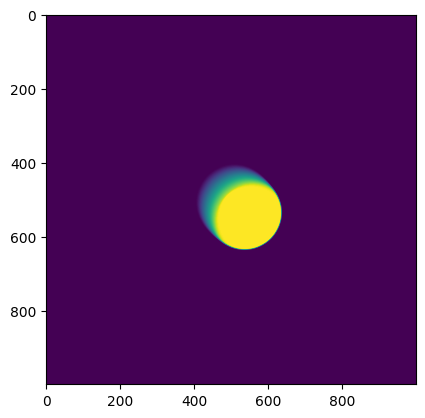

In [ ]:
i=0
while i < len(solution):
  plt.imshow(solution[i])
  plt.show()
  i +=20